#### Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_excel('../data/data.xlsx')

In [4]:
data.columns

Index(['Nombre y apellidos', 'Edad', 'Sexo', 'App HTA', 'App DM', 'App AB',
       'App Cardiopatía Isquémica', 'App Vasculitis', 'App Colagenopatías',
       'Etiología del empaquetamiento', 'Número de compresas utilizadas',
       'Horas transcurridas al desempaquetamiento',
       'Daño orgánico tubular asociado', 'Peritonitis asociada',
       'Lesión de vía biliar asociada',
       'Presencia de hipotensión arterial o shock  ', 'Tiempo quirúrgico',
       '# de hemoderivados  usados', 'componentes triada letal',
       'traumas asociado', 'VAM', 'Reempaquetamiento', 'Apache II', 'Sofa',
       'Estado al egreso'],
      dtype='object')

In [5]:
data.drop('Nombre y apellidos', axis=1, inplace = True)

#### Analysis of Clinical Outcome Distribution 

The distribution of clinical outcomes was analyzed using visualization and frequency counts:

Text(0, 0.5, 'Número de casos')

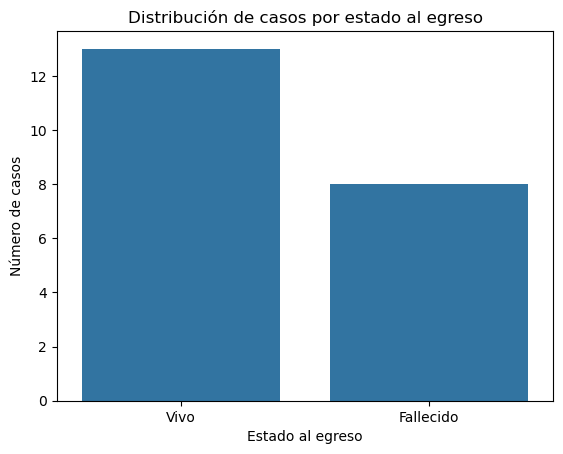

In [6]:
sns.countplot(x='Estado al egreso', data=data)
plt.title('Distribución de casos por estado al egreso')
plt.xticks(ticks=[0, 1], labels=['Vivo', 'Fallecido'])
plt.xlabel('Estado al egreso')
plt.ylabel('Número de casos')

In [7]:
data['Estado al egreso'].value_counts()

Estado al egreso
1    13
2     8
Name: count, dtype: int64

#### Key Findings

1-Class Distribution Balance

- **Alive patients:** 13 cases (61.9%)
- **Deceased patients:** 8 cases (38.1%)
- **Ratio:** 1.6:1 (Alive:Deceased)

The distribution demonstrates acceptable balance for predictive modeling without requiring aggressive rebalancing techniques.

2-Dataset Size Characteristics

- **Total clinical cases:** 21 patients

Classification as a small dataset necessitates:
- Specialized validation approaches (e.g., Leave-One-Out Cross-Validation)
- Simplified model architectures with minimal parameters
- Rigorous feature selection methodologies
- Careful interpretation of results

3-Clinical Significance

- **Observed mortality rate:** 38.1%

This reflects the high-severity clinical context of damage control surgery and aligns with literature expectations for critical trauma interventions. It confirms that the dataset represents a clinically relevant patient cohort.

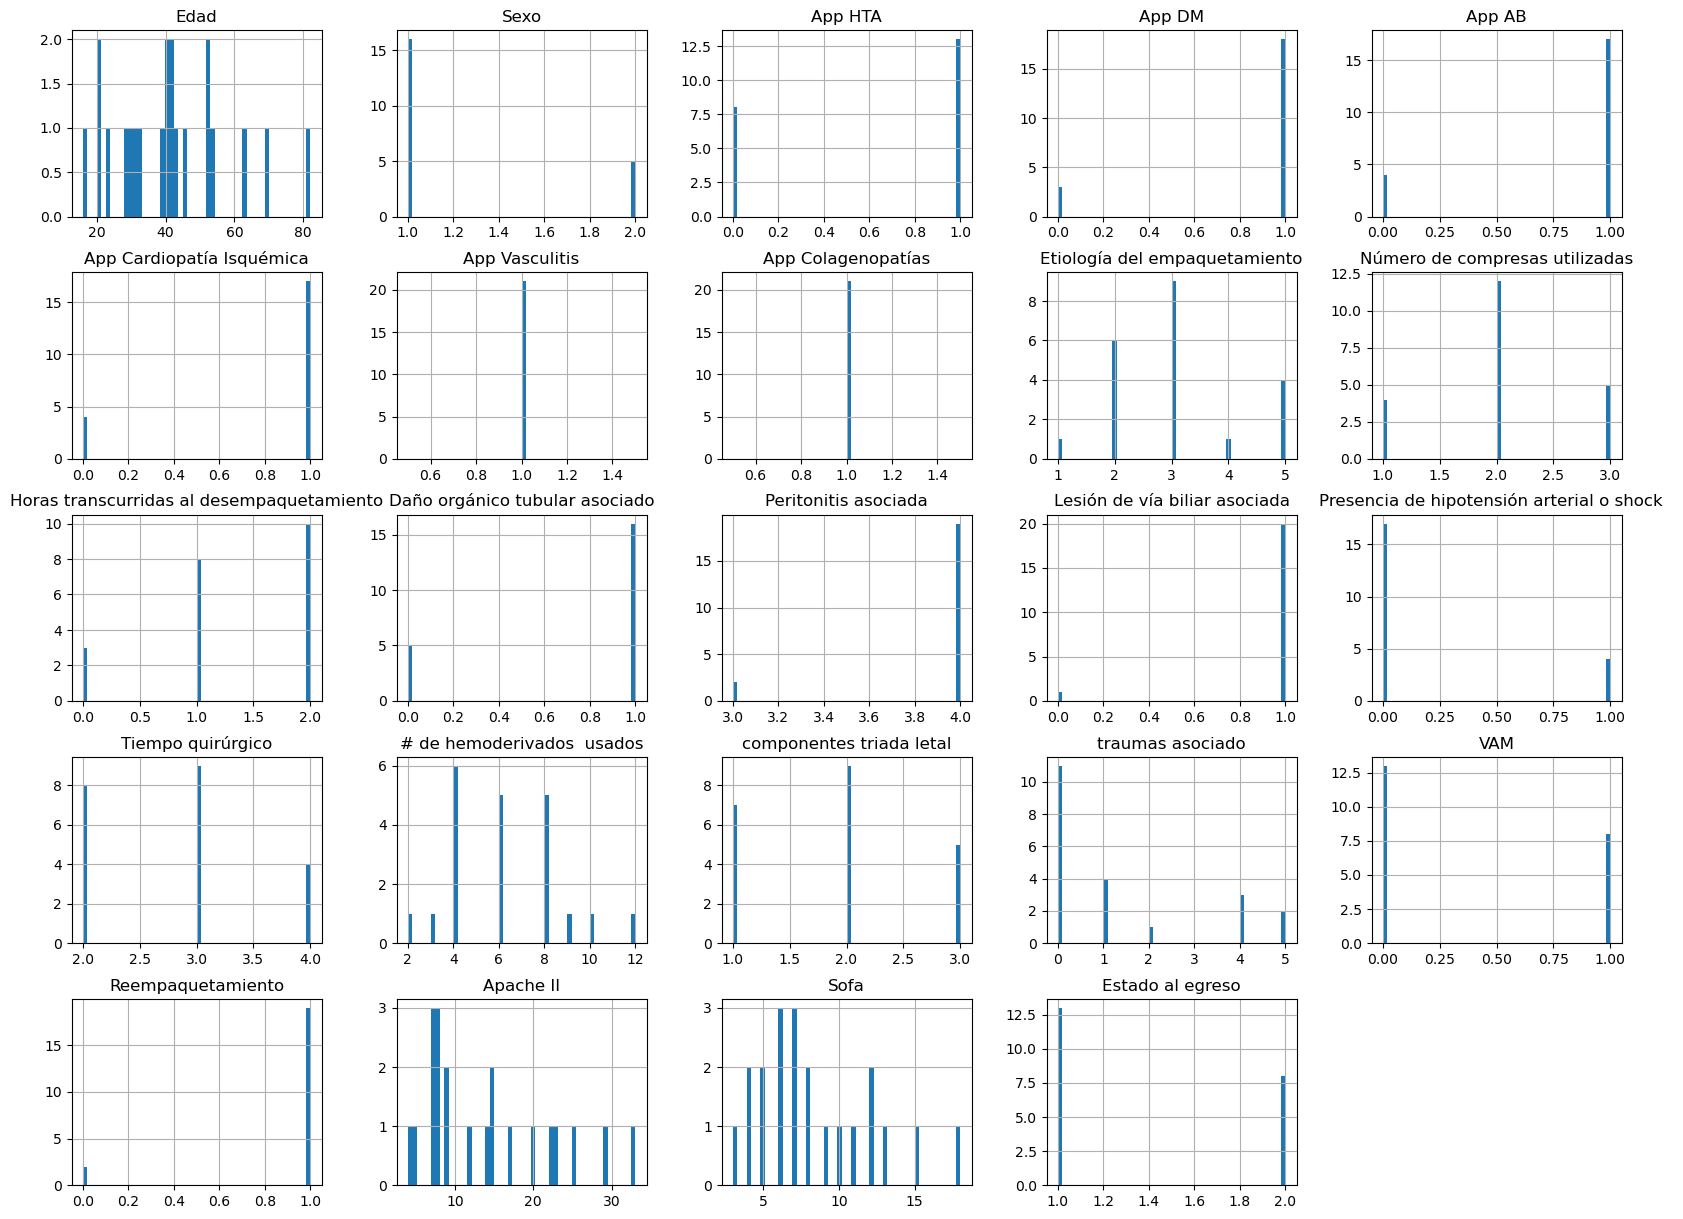

In [8]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
y = data['Estado al egreso']
X = data.drop('Estado al egreso', axis=1)

#### Feature Variance Assessment  
Understanding feature variability is a critical step in exploratory data analysis to identify informative predictors and potential issues. 

Scaling enables fair comparison of variance across features measured in different units.

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

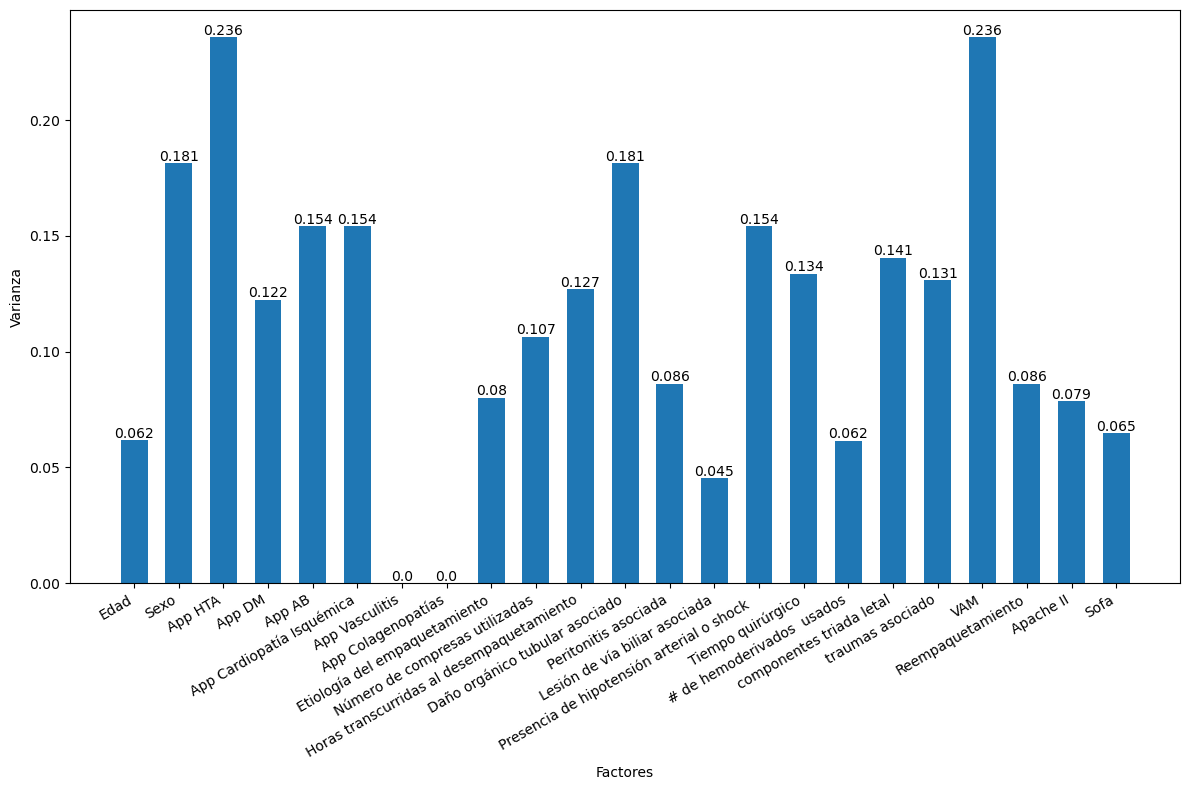

In [11]:
fig , ax = plt.subplots()

fig.set_size_inches(12,8)

x = X.columns
y_ = scaled_X.var(axis=0)

ax.bar(x, y_, width=0.6)
ax.set_xlabel('Factores')
ax.set_ylabel('Varianza')

for index, value in enumerate(y_):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')
    
fig.autofmt_xdate()
plt.tight_layout()


In [12]:
X.drop(['App Vasculitis', 'App Colagenopatías'], axis=1, inplace=True)

The columns were removed due to their zero variance, as they do not provide any informative value and contribute unnecessary noise to the dataset.

<Axes: >

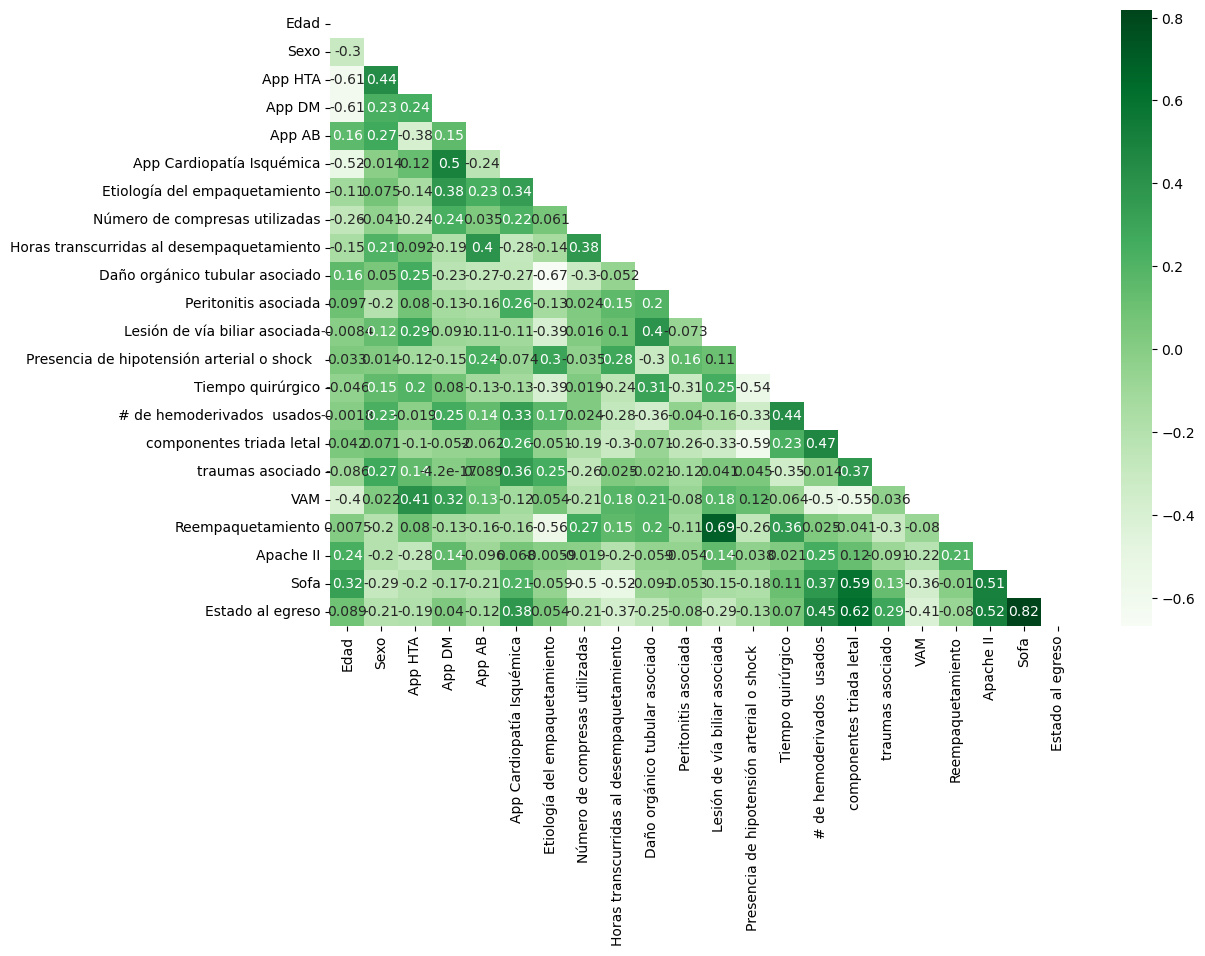

In [13]:
matrix = X.join(y).corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(12,8))
sns.heatmap(matrix, annot=True, cmap='Greens', mask=mask)


In [14]:
matrix['Estado al egreso'].sort_values(ascending=False)

Estado al egreso                               1.000000
Sofa                                           0.819522
componentes triada letal                       0.622669
Apache II                                      0.516811
# de hemoderivados  usados                     0.453623
App Cardiopatía Isquémica                      0.380521
traumas asociado                               0.289214
Edad                                           0.089428
Tiempo quirúrgico                              0.070213
Etiología del empaquetamiento                  0.053582
App DM                                         0.040032
Peritonitis asociada                          -0.079536
Reempaquetamiento                             -0.079536
App AB                                        -0.118913
Presencia de hipotensión arterial o shock     -0.130804
App HTA                                       -0.192308
Número de compresas utilizadas                -0.207397
Sexo                                          -0

### Clinical Profile Analysis Using Parallel Coordinates

A parallel coordinates plot was generated to interactively identify which variable combinations might serve as predictive factors for patient discharge outcomes, complementing the correlation analysis.Each line represents an individual patient, color-coded by discharge status (green: survived, red: deceased) and the vertical axes display normalized clinical variables for standardized comparison

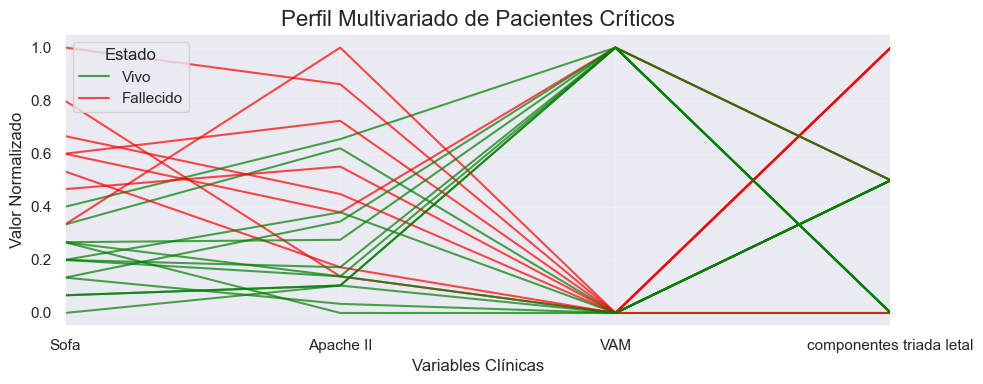

In [20]:

key_vars = ['Sofa', 'Apache II', 'VAM','componentes triada letal', 'Estado al egreso']
subset = data[key_vars].copy()

numeric_cols = key_vars[:-1]  

scaled_values = scaler.fit_transform(subset[numeric_cols].astype(float))
scaled_df = pd.DataFrame(scaled_values, columns=numeric_cols)
scaled_df['Estado al egreso'] = subset['Estado al egreso'].values


color_map = {1: 'green', 2: 'red'} 
colors = scaled_df['Estado al egreso'].map(color_map)


plt.figure(figsize=(10, 4))
pd.plotting.parallel_coordinates(
    scaled_df, 
    'Estado al egreso',
    color=colors.tolist(),
    axvlines=False,
    alpha=0.7
)


plt.title('Perfil Multivariado de Pacientes Críticos', fontsize=16)
plt.ylabel('Valor Normalizado', fontsize=12)
plt.xlabel('Variables Clínicas', fontsize=12)
plt.grid(alpha=0.2)
plt.legend(title='Estado', labels=['Vivo', 'Fallecido'])
plt.tight_layout()
plt.show()


#### Interpretation:

- **Risk Patterns**: Clustering of red lines (deceased patients) in specific ranges (elevated APACHE II and SOFA scores) suggests potential mortality-associated thresholds

- **Profile Overlap**: Intersections between differently colored lines indicate limitations in individual variables' predictive power as seen in componentes triada letal feature 

### Bivariate Analysis: SOFA vs APACHE II Scores

Text(0.5, 0, 'Sofa')

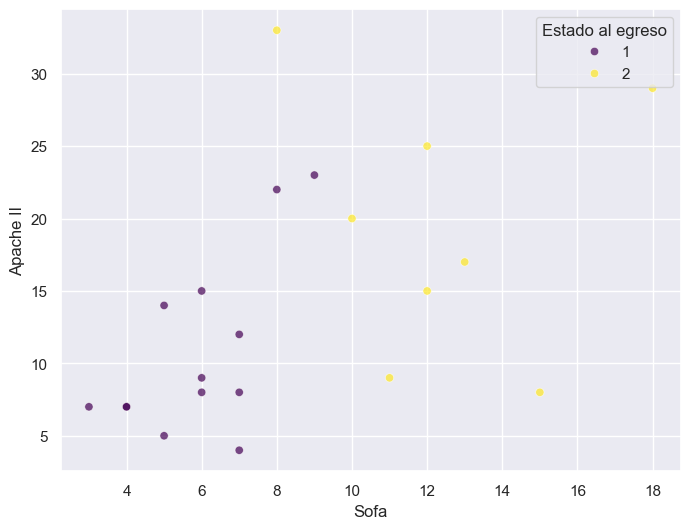

In [16]:
plt.figure(figsize=(8, 6))
sns.set(style='darkgrid')
sns.scatterplot(x='Sofa', y ='Apache II', data = data, hue='Estado al egreso', alpha =0.7, palette='viridis')
plt.ylabel('Apache II')
plt.xlabel('Sofa')

#### Key observations:

- Clear non-linear relationship between SOFA and APACHE II scores

- Distinct separation between outcome groups (survived vs deceased)

- Higher scores in both parameters correlate with worse outcomes

In [17]:
data = X.join(y)
data.to_csv('../data/data.csv', index=False)